In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Lire datasets

def read_ds(ds_name: str):
    with open(f'{ds_name}.csv') as f:
        max_actions = max(( len( str(c).split(",")) for c in f.readlines() ))
        f.seek(0)
        _names = ["util", "navigateur"] if "train" in ds_name else ["navigateur"]
        _names.extend(range(max_actions - len(_names)))
        return pd.read_csv(f, names=_names, dtype= str)

features_train = read_ds("train")
features_test = read_ds("test")

features_train.head()

,util,navigateur,0,1,2,3,4,5,6,7,...,14458,14459,14460,14461,14462,14463,14464,14465,14466,14467
0,nuh,Firefox,Création d'un écran(infologic.core.accueil.Acc...,Affichage d'une dialogue,Exécution d'un bouton,Fermeture d'une dialogue,Affichage d'une dialogue,Exécution d'un bouton,Fermeture d'une dialogue,Création d'un écran(infologic.core.gui.control...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,muz,Google Chrome,Création d'un écran(infologic.core.gui.control...,Création d'un écran(infologic.core.gui.control...,t5,Sélection d’un onglet(infologic.orga.modules.O...,t10,Exécution d'un bouton,t15,Sélection d’un onglet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,zrx,Microsoft Edge,Affichage d'une dialogue(infologic.core.gui.co...,Exécution d'un bouton,Chainage,Fermeture d'une dialogue,Affichage d'une dialogue(infologic.acti.module...,Clic sur une grille d'historique de recherche,Raccourci,Fermeture d'une dialogue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,pou,Firefox,Création d'un écran(infologic.core.gui.control...,t5,Exécution d'un bouton(MAINT),Affichage d'une dialogue,Fermeture d'une dialogue,Double-clic,Exécution d'un bouton,Lancement d'une stat(infologic.core.gui.contro...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ald,Google Chrome,Affichage d'une dialogue(infologic.acti.module...,t5,Exécution d'un bouton,Fermeture d'une dialogue,t10,Entrée en saisie dans un formulaire,t10,Affichage d'une dialogue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def filter_action(value: str):
    """Enlève les détails d'une action, ex: 'Création d'un écran(infologic...)' -> 'Création d'un écran'."""
    for delim in [ "(", "<", "$", "1"]:
        if delim in value and (low_ind := value.index(delim)):
            value = value[:low_ind]
    return value

# Définition des expressions régulières (regex) pour extraire des infos spécifiques
pattern_ecran = re.compile(r"\((.*?)\)")        # Pour extraire le contenu entre ( ... )
pattern_conf_ecran = re.compile(r"<(.*?)>")   # Pour extraire le contenu entre < ... >
pattern_chaine = re.compile(r"\$(.*?)\$")      # Pour extraire le contenu entre $ ... $

In [5]:
uniques = features_train.iloc[:,2:].stack().dropna().unique()


filtered_uniques = list(set([filter_action(un) for un in uniques if not un.startswith("t")]))

print(f"Nombre d'actions brutes uniques (avec 't...'): {len(uniques)}")
print(f"Nombre d'actions 'filtrées' uniques (sans 't...'): {len(filtered_uniques)}")


print("\nExemple des 10 premières actions 'filtrées' (Tableau) :")

df_sample = pd.DataFrame(filtered_uniques[:], columns=['Exemple d\'action filtrée'])

display(df_sample)


Nombre d'actions brutes uniques (avec 't...'): 9445
Nombre d'actions 'filtrées' uniques (sans 't...'): 35

Exemple des 10 premières actions 'filtrées' (Tableau) :


,Exemple d'action filtrée
0,Entrée en saisie dans un formulaire
1,Exécution d'un bouton
2,Retour sur un écran
3,Sélection d'un flag
4,Filtrage / Tri
5,Erreur système grave
6,Dissimulation d'une arborescence
7,Affichage d'un toast
8,Lancement d'une action infocentre
9,Clic long


In [6]:
def create_features(df_raw, all_action_types):

    features_list = []
    # Détermine les colonnes d'action
    is_train = 'util' in df_raw.columns
    id_cols = ['util', 'navigateur'] if is_train else ['navigateur']
    action_cols = df_raw.columns.difference(id_cols)

    # Itère sur chaque ligne (session) du DataFrame brut
    print(f"Début du traitement de {len(df_raw)} lignes...")
    for index, row in df_raw.iterrows():

        row_features = {} # Dictionnaire pour les features de CETTE ligne

        # 1. Ajoute les identifiants
        if is_train:
            row_features['util'] = row['util']
        row_features['navigateur'] = row['navigateur']

        # 2. Obtient la liste des actions pour cette session (en ignorant les NaN)
        actions = [str(a) for a in row[action_cols].dropna()]

        # 3. Sépare les actions réelles des marqueurs de temps
        real_actions = [a for a in actions if not a.startswith('t')]
        time_markers = [a for a in actions if a.startswith('t')]

        # --- CRÉATION DES FEATURES ---

        # 4. Features simples (comptages)
        row_features['total_actions_brutes'] = len(actions) # Actions + temps
        row_features['total_actions_reelles'] = len(real_actions) # Juste les actions
        row_features['total_actions_reelles_uniques'] = len(set(real_actions))
        row_features['total_marqueurs_temps'] = len(time_markers)

        # 5. Feature de durée (approximative, en multiples de 5 sec)
        total_time = 0
        for t in time_markers:
            try:
                total_time += int(t[1:])
            except ValueError:
                pass
        row_features['duree_session_approx'] = total_time

        all_actions_str = " ".join(real_actions)
        # 6. Features basées sur les regex
        ecrans = pattern_ecran.findall(all_actions_str)
        confs = pattern_conf_ecran.findall(all_actions_str)
        chaines = pattern_chaine.findall(all_actions_str)

        row_features['count_ecran'] = len(ecrans)
        row_features['count_conf_ecran'] = len(confs)
        row_features['count_chaine'] = len(chaines)

        # 7. Feature catégorielle : Écran le plus fréquent
        if ecrans:
            row_features['ecran_plus_frequent'] = Counter(ecrans).most_common(1)[0][0]
        else:
            row_features['ecran_plus_frequent'] = 'None'

        # 8. Features "Bag-of-Actions" (une colonne par type d'action)
        action_counts_dict = Counter([filter_action(a) for a in real_actions])

        for action_type in all_action_types:
            col_name = f'count_{action_type}'
            row_features[col_name] = action_counts_dict.get(action_type, 0)
        features_list.append(row_features)

        if (index + 1) % 1000 == 0:
            print(f"  ... {index + 1} lignes traitées")

    # 9. Crée le DataFrame final
    print("Toutes les lignes traitées. Création du DataFrame final...")
    features_df = pd.DataFrame(features_list)
    features_df['ecran_plus_frequent'] = features_df['ecran_plus_frequent'].fillna('None')

    return features_df


In [7]:
# Génération du DataFrame de features pour l'entraînement
train_df_features = create_features(features_train, filtered_uniques)

# Génération du DataFrame de features pour le test
test_df_features = create_features(features_test, filtered_uniques)


print(f"Shape du nouveau DataFrame 'train' : {train_df_features.shape}")
print(f"Shape du nouveau DataFrame 'test' : {test_df_features.shape}")

print("\nAperçu du nouveau DataFrame de features (train_df_features) :")
# Affiche plus de colonnes pour bien voir la transformation
pd.set_option('display.max_columns', 100)
display(train_df_features)

Début du traitement de 3279 lignes...
  ... 1000 lignes traitées
  ... 2000 lignes traitées
  ... 3000 lignes traitées
Toutes les lignes traitées. Création du DataFrame final...
Début du traitement de 324 lignes...
Toutes les lignes traitées. Création du DataFrame final...
Shape du nouveau DataFrame 'train' : (3279, 46)
Shape du nouveau DataFrame 'test' : (324, 45)

Aperçu du nouveau DataFrame de features (train_df_features) :


,util,navigateur,total_actions_brutes,total_actions_reelles,total_actions_reelles_uniques,total_marqueurs_temps,duree_session_approx,count_ecran,count_conf_ecran,count_chaine,ecran_plus_frequent,count_Entrée en saisie dans un formulaire,count_Exécution d'un bouton,count_Retour sur un écran,count_Sélection d'un flag,count_Filtrage / Tri,count_Erreur système grave,count_Dissimulation d'une arborescence,count_Affichage d'un toast,count_Lancement d'une action infocentre,count_Clic long,count_Chainage,count_Affichage d'une dialogue,count_Désélection d'un élément,count_Saisie dans un champ,count_Ouverture d'un panel,count_Affichage d'une erreur,count_Création d'un écran,count_Fermeture de session,count_Sélection d’un onglet,count_Lancement d'une action générique,count_Raccourci dans l'édition de table,count_Sélection d'un élément,count_Sélection d'un écran,count_Fermeture d'une dialogue,count_Fermeture d'un panel,count_Désélection d'un flag,count_Affichage d'une arborescence,count_Clic sur une checkbox,count_Démarrage serveur d'application Tomcat,count_Action de table,count_Raccourci,count_Lancement d'un tableau de bord,count_Lancement d'une stat,count_Clic sur une grille d'historique de recherche,count_Double-clic
0,nuh,Firefox,3128,2514,53,614,895130,191,7,899,MAINT,0,698,2,0,161,0,0,311,0,0,8,350,0,198,0,6,72,1,6,124,0,0,23,369,0,0,1,0,0,11,0,0,85,1,87
1,muz,Google Chrome,136,90,23,46,5405,8,4,43,infologic.orga.modules.OR_FICHIERTRAVAIL.Insta...,0,33,0,0,0,0,0,1,0,0,3,2,0,34,0,0,3,0,3,5,0,0,3,2,0,0,0,0,0,0,1,0,0,0,0
2,zrx,Microsoft Edge,766,608,84,158,59285,94,35,52,DEMTEST,0,122,4,0,1,0,0,7,0,0,32,35,11,46,1,0,36,0,21,35,0,10,68,38,1,0,1,0,0,6,39,0,0,72,22
3,pou,Firefox,1199,886,56,313,229405,249,9,203,MAINT,0,279,17,60,5,0,0,2,0,0,23,42,0,84,0,1,22,1,0,26,0,0,50,42,0,0,0,0,1,7,0,0,101,121,2
4,ald,Google Chrome,233,173,37,60,8185,21,7,11,MAINT,22,60,0,0,0,0,0,1,0,0,4,10,0,14,0,0,10,1,0,7,0,0,19,10,0,0,0,0,0,3,0,0,0,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,muz,Google Chrome,149,122,37,27,1890,12,7,50,infologic.orga.modules.OR_FICHIERTRAVAIL.Insta...,8,30,17,0,0,0,0,0,0,0,4,9,0,19,0,1,5,0,1,8,0,0,5,8,0,0,0,0,0,0,5,0,0,1,1
3275,cjr,Google Chrome,585,439,66,146,53655,81,32,4,infologic.crm.modules.CRM_PLANNING.planning.Pl...,0,137,4,0,1,0,1,7,0,0,6,50,7,55,0,4,14,0,12,7,0,7,52,50,0,0,1,0,0,11,2,0,6,2,3
3276,fuz,Firefox,1823,1457,116,366,315380,228,62,367,infologic.core.gui.controllers.BlankController,0,226,8,100,1,0,2,19,0,0,46,88,0,107,2,9,52,1,234,56,0,0,121,87,1,0,1,2,0,2,275,0,0,9,8
3277,cjr,Google Chrome,860,630,74,230,132825,88,29,0,infologic.crm.modules.CRM_PLANNING.planning.Pl...,0,164,9,0,0,0,16,9,0,0,6,43,0,105,5,1,28,0,47,9,0,0,47,43,8,0,30,2,1,24,3,0,19,9,2


In [8]:
features_train["util"] = pd.Categorical(features_train["util"])
def to_categories(df, col="util"):
    df[col] = df[col].cat.codes
to_categories(features_train)

In [9]:
# Analyse variables numériques
summary_stat = train_df_features.describe()
summary_stat

,total_actions_brutes,total_actions_reelles,total_actions_reelles_uniques,total_marqueurs_temps,duree_session_approx,count_ecran,count_conf_ecran,count_chaine,count_Entrée en saisie dans un formulaire,count_Exécution d'un bouton,count_Retour sur un écran,count_Sélection d'un flag,count_Filtrage / Tri,count_Erreur système grave,count_Dissimulation d'une arborescence,count_Affichage d'un toast,count_Lancement d'une action infocentre,count_Clic long,count_Chainage,count_Affichage d'une dialogue,count_Désélection d'un élément,count_Saisie dans un champ,count_Ouverture d'un panel,count_Affichage d'une erreur,count_Création d'un écran,count_Fermeture de session,count_Sélection d’un onglet,count_Lancement d'une action générique,count_Raccourci dans l'édition de table,count_Sélection d'un élément,count_Sélection d'un écran,count_Fermeture d'une dialogue,count_Fermeture d'un panel,count_Désélection d'un flag,count_Affichage d'une arborescence,count_Clic sur une checkbox,count_Démarrage serveur d'application Tomcat,count_Action de table,count_Raccourci,count_Lancement d'un tableau de bord,count_Lancement d'une stat,count_Clic sur une grille d'historique de recherche,count_Double-clic
count,3279.000000,3279.000000,3279.000000,3279.000000,3.279000e+03,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000,3279.000000
mean,850.238792,692.359561,58.633425,157.879231,1.665692e+05,87.976517,31.611467,110.301921,11.978042,155.731930,18.891735,9.835926,11.475450,0.004880,1.739555,15.886246,0.090881,0.093626,20.797194,51.518146,5.088747,81.010369,0.888381,2.969198,23.461421,0.587069,33.305581,35.157975,0.070143,5.172309,63.071973,52.157975,1.158890,0.521500,2.905154,3.365660,0.207990,5.555657,25.061299,8.035682,8.495578,15.331808,20.735590
std,1212.323701,1005.873878,40.233756,212.513833,6.736851e+05,131.705517,47.040981,261.872217,56.918641,227.105577,57.742820,47.730328,48.344124,0.073941,10.136403,47.408872,1.424414,0.477772,35.535759,86.990677,23.790813,124.498398,5.800453,5.517013,37.205606,0.598680,90.667392,102.853634,0.804553,23.827589,126.594356,87.689093,8.529606,8.706702,19.522749,11.436092,0.800806,17.189835,82.665355,32.316015,21.063877,51.766887,60.590001
min,2.000000,0.000000,0.000000,1.000000,5.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,192.000000,153.000000,30.000000,38.000000,3.570000e+03,19.000000,5.000000,0.000000,0.000000,35.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,10.000000,0.000000,15.000000,0.000000,0.000000,6.000000,0.000000,2.000000,3.000000,0.000000,0.000000,7.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,423.000000,340.000000,48.000000,82.000000,1.645000e+04,43.000000,14.000000,17.000000,0.000000,78.000000,4.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,8.000000,25.000000,0.000000,39.000000,0.000000,1.000000,12.000000,1.000000,7.000000,11.000000,0.000000,0.000000,24.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,2.000000,1.000000,5.000000
75%,1019.000000,818.500000,75.000000,197.500000,9.444000e+04,103.000000,37.000000,90.000000,0.000000,190.000000,13.000000,0.000000,4.000000,0.000000,0.000000,11.000000,0.000000,0.000000,23.000000,61.000000,0.00

In [10]:
print("Valeurs distinctes et leurs fréquences pour la colonne 'navigateur' :")
print(features_train['navigateur'].value_counts())



# Regrouper par utilisateur et compter le nombre d'occurrences de chaque navigateur
browsers_per_user = features_train.groupby('util')['navigateur'].value_counts().unstack(fill_value=0)


def browsers_per_player(df):
    return browsers_per_user


display(browsers_per_player(features_train))

Valeurs distinctes et leurs fréquences pour la colonne 'navigateur' :
navigateur
Firefox           1466
Google Chrome     1339
Microsoft Edge     451
Opera               23
Name: count, dtype: int64


navigateur,Firefox,Google Chrome,Microsoft Edge,Opera
util,,,,
0,0,10,0,0
1,13,0,0,0
2,0,14,0,0
3,0,15,0,0
4,12,0,0,0
...,...,...,...,...
242,0,0,16,0
243,13,0,0,0
244,0,0,12,0


,Count,Proportion (%)
util,,
171,75,2.29
172,71,2.17
21,46,1.40
54,42,1.28
76,37,1.13
...,...,...
89,4,0.12
86,4,0.12
112,4,0.12


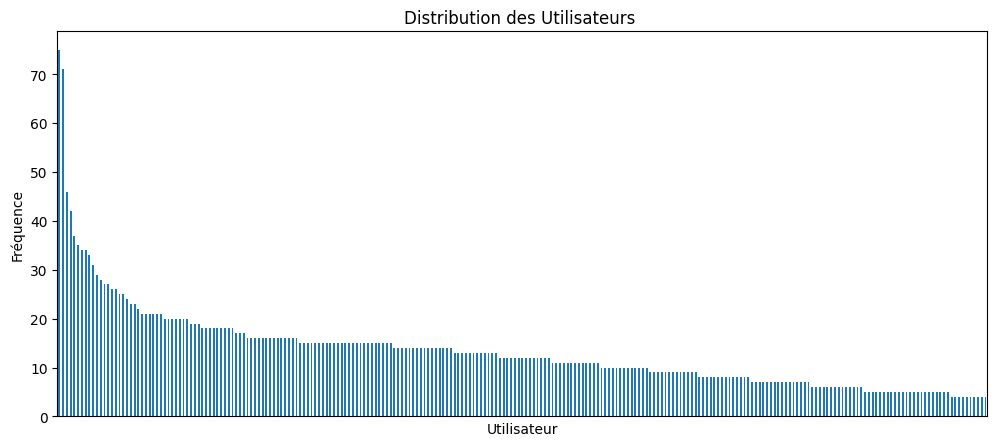

In [11]:
def get_Y_stats(df):
    # Compter les occurrences de chaque utilisateur
    util_counts = df['util'].value_counts().sort_values(ascending=False)
    # Calculer la proportion de chaque utilisateur
    util_proportions = df['util'].value_counts(normalize=True).mul(100).round(2)
    # Créer un DataFrame pour l'affichage
    stats_df = pd.DataFrame({'Count': util_counts, 'Proportion (%)': util_proportions})
    return stats_df

display(get_Y_stats(features_train))

# Affichage d'un graphique de la distribution de Y

plt.figure(figsize=(12, 5))
features_train['util'].value_counts().plot(kind='bar')
plt.title('Distribution des Utilisateurs ')
plt.xlabel('Utilisateur')
plt.ylabel('Fréquence')
plt.xticks([])
plt.show()

In [12]:
features_train["util"] = pd.Categorical(features_train["util"])
def to_categories(df, col="util"):

    df[col] = df[col].cat.codes

to_categories(features_train)


features_df = train_df_features.copy()


features_for_plot = features_df.drop(columns=['util', 'navigateur', 'ecran_plus_frequent'], errors='ignore')

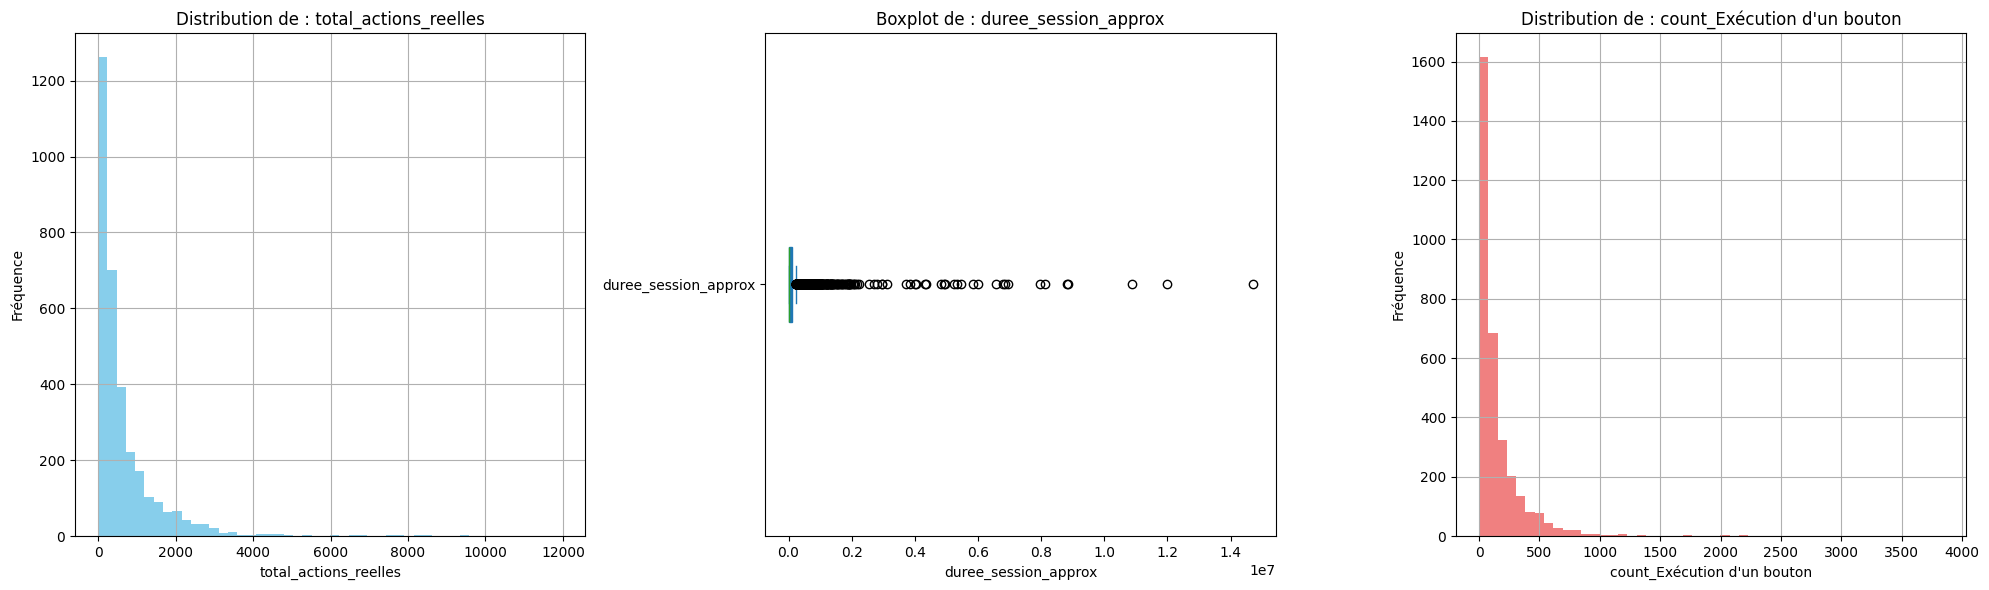

In [13]:
# Choix de trois caractéristiques numériques à afficher

feature_names = [
    'total_actions_reelles',
    'duree_session_approx',
    'count_Exécution d\'un bouton'
]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(20,6))

# Histogramme pour la première feature
features_for_plot[feature_names[0]].hist(ax=ax1, bins=50, color='skyblue')
ax1.set_title(f'Distribution de : {feature_names[0]}')
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel('Fréquence')

# Boxplot pour la deuxième feature (pour visualiser les outliers et la dispersion)
features_for_plot[feature_names[1]].plot(kind='box', ax=ax2, vert=False, patch_artist=True)
ax2.set_title(f'Boxplot de : {feature_names[1]}')
ax2.set_xlabel(feature_names[1])

# Boxplot (ou Histogramme) pour la troisième feature
features_for_plot[feature_names[2]].hist(ax=ax3, bins=50, color='lightcoral')
ax3.set_title(f'Distribution de : {feature_names[2]}')
ax3.set_xlabel(feature_names[2])
ax3.set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

Nombre de colonnes numériques pour la corrélation : 43


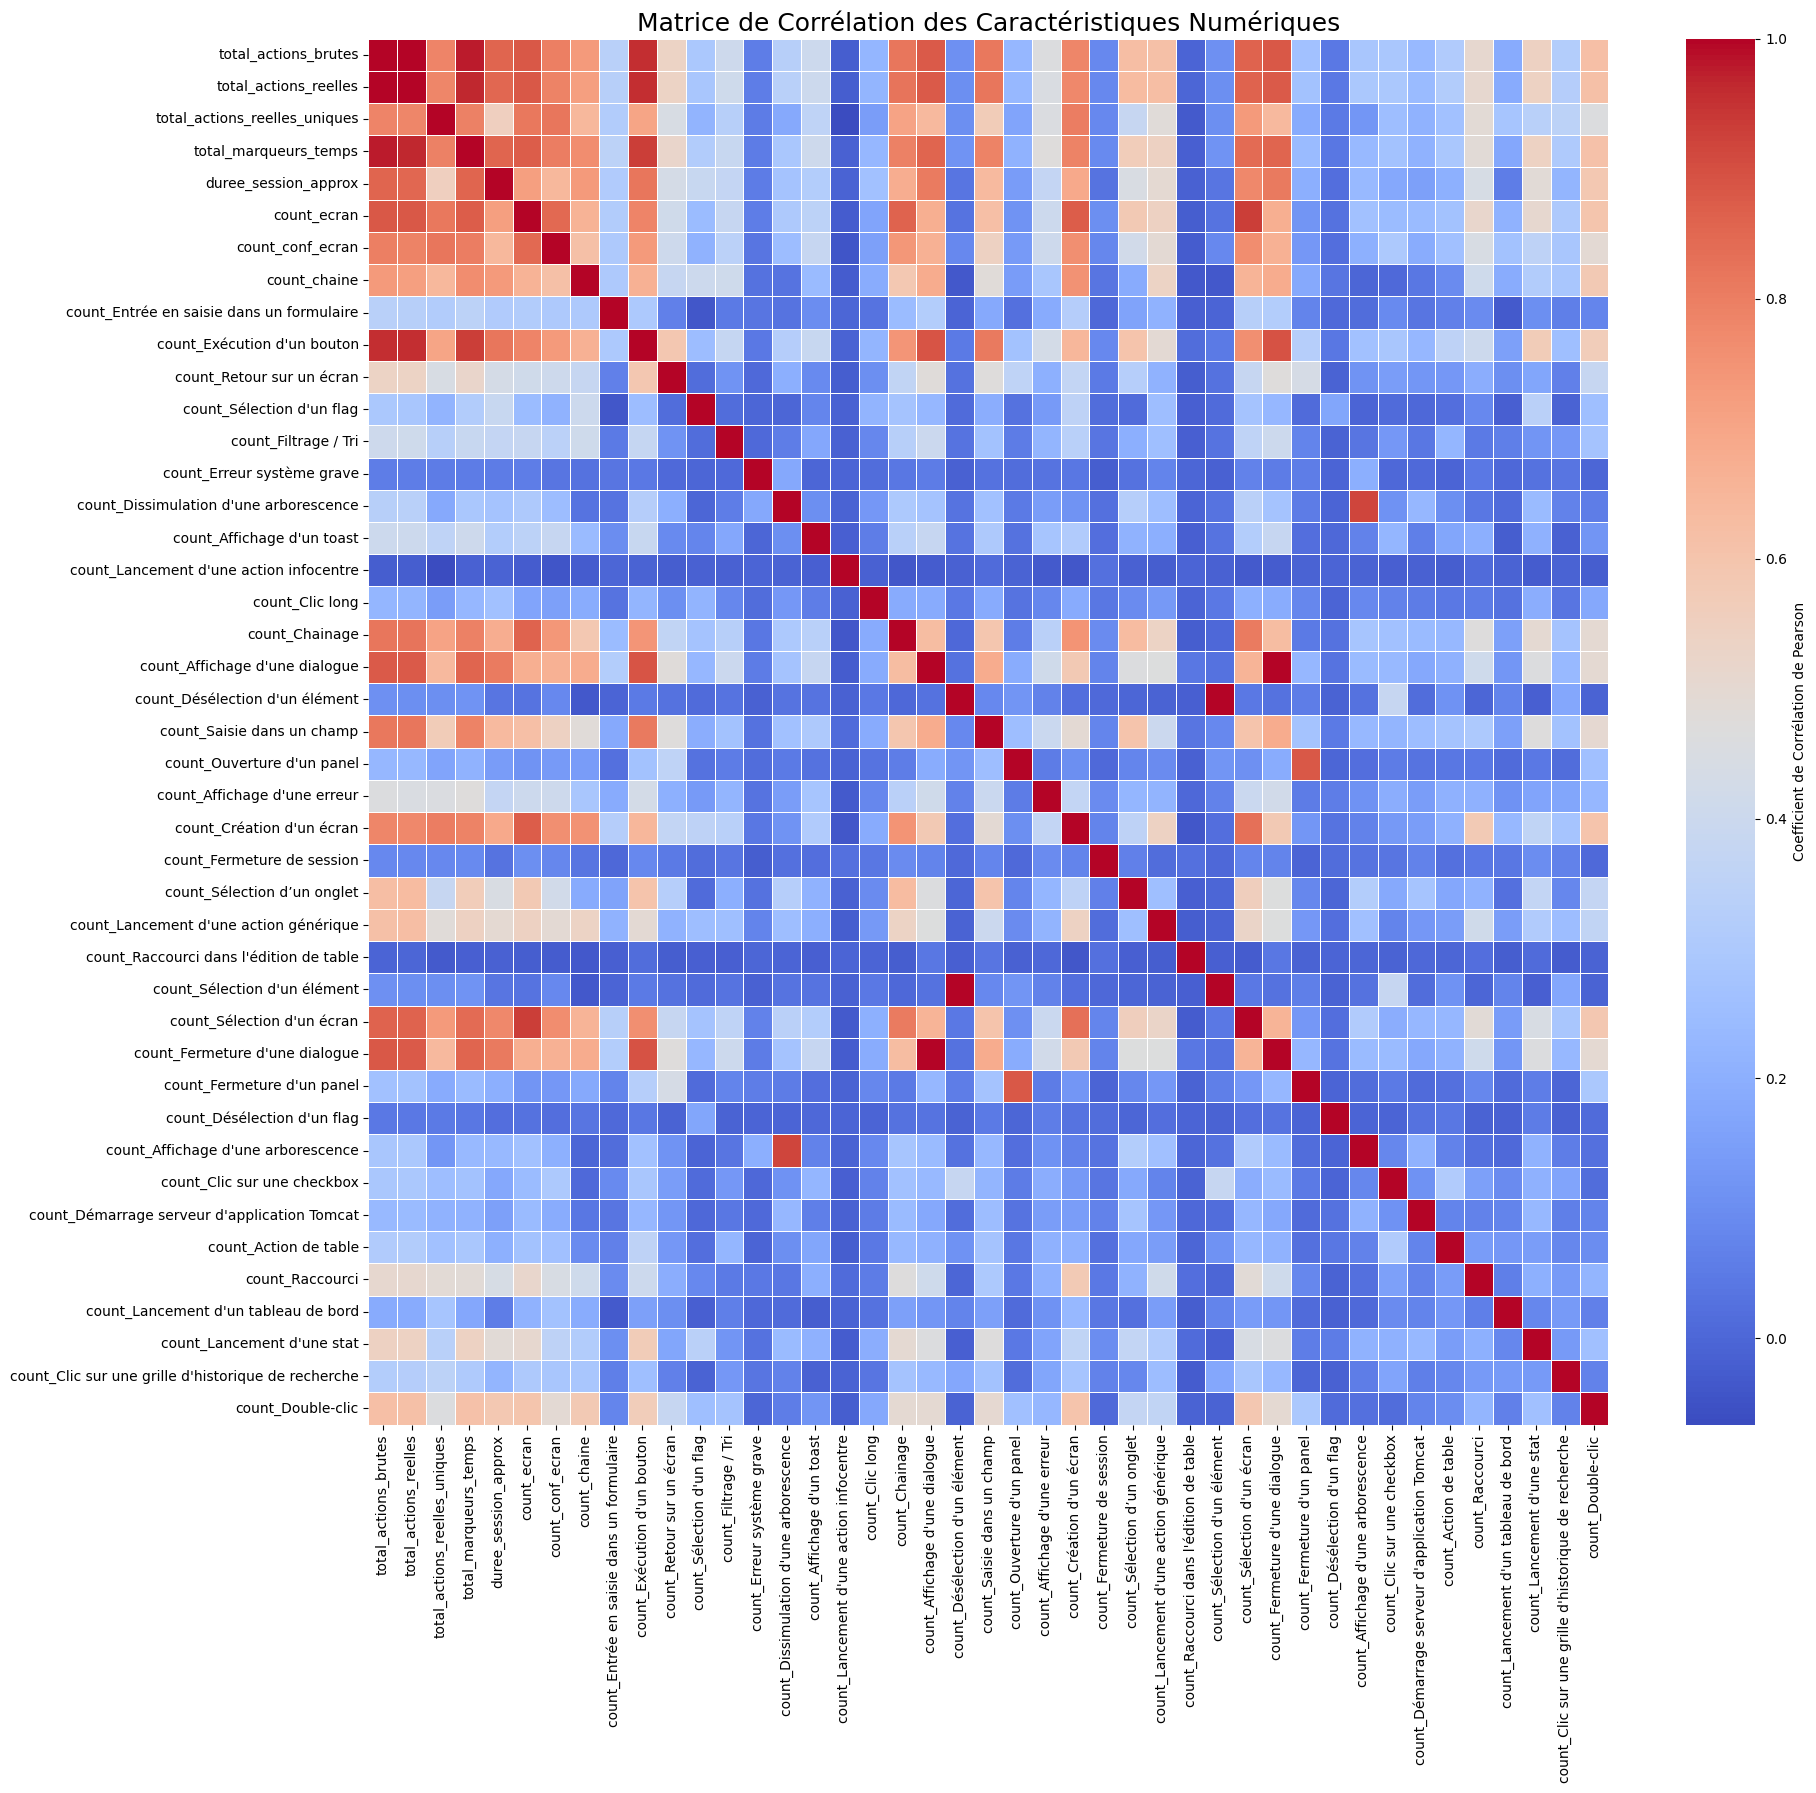

In [14]:
# Exclure les colonnes de type 'object' (chaînes de caractères)
numeric_features_df = features_df.select_dtypes(include=np.number)


print(f"Nombre de colonnes numériques pour la corrélation : {numeric_features_df.shape[1]}")
# Calcul de la matrice de corrélation (méthode de Pearson)
correlation_matrix = numeric_features_df.corr()

# Configuration de la figure
plt.figure(figsize=(20, 18))


sns.heatmap(
    correlation_matrix,
    annot=False,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=.5,
    cbar_kws={'label': 'Coefficient de Corrélation de Pearson'}
)

plt.title('Matrice de Corrélation des Caractéristiques Numériques', fontsize=18)
plt.show()

In [15]:
# 1. Sélectionner uniquement la colonne navigateur
browser_ohe = pd.get_dummies(features_df['navigateur'], prefix='nav')

# 2. Concaténer les nouvelles colonnes (une par navigateur) au DataFrame de features
features_df = pd.concat([features_df.drop('navigateur', axis=1), browser_ohe], axis=1)

# 3. Supprimer les lignes avec des valeurs manquantes (NaN) si nécessaire

features_df.dropna(inplace=True)

print(f"Nouvelle taille du DataFrame après OHE et nettoyage: {features_df.shape}")

Nouvelle taille du DataFrame après OHE et nettoyage: (3279, 49)


In [16]:
features_df['util'] = pd.Categorical(features_df['util'])
features_df['util'] = features_df['util'].cat.codes

# Y est la variable cible (l'utilisateur)
Y = features_df['util']
# X contient toutes les features (en excluant 'util' et 'ecran_plus_frequent')
X = features_df.drop(['util', 'ecran_plus_frequent'], axis=1)


class_counts = Y.value_counts()
single_sample_classes = class_counts[class_counts == 1].index


features_df_filtered = features_df[~features_df['util'].isin(single_sample_classes)]


Y_filtered = features_df_filtered['util']
X_filtered = features_df_filtered.drop(['util', 'ecran_plus_frequent'], axis=1)



X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, Y_filtered,
    test_size=0.2,
    random_state=42,
    stratify=Y_filtered
)

print(f"Taille de l'ensemble d'entraînement: {X_train.shape}")
print(f"Taille de l'ensemble de validation: {X_val.shape}")

Taille de l'ensemble d'entraînement: (2623, 47)
Taille de l'ensemble de validation: (656, 47)


In [17]:
# Appliquer le categorical encoding pour 'util'
features_df['util'] = pd.Categorical(features_df['util'])
features_df['util'] = features_df['util'].cat.codes

# Y est la variable cible (l'utilisateur)
Y = features_df['util']
# X contient toutes les features (en excluant 'util' et 'ecran_plus_frequent')
X = features_df.drop(['util', 'ecran_plus_frequent'], axis=1)

# Identifier les classes
class_counts = Y.value_counts()
single_sample_classes = class_counts[class_counts == 1].index


features_df_filtered = features_df[~features_df['util'].isin(single_sample_classes)]

# Mise à jour pour X et Y with
Y_filtered = features_df_filtered['util']
X_filtered = features_df_filtered.drop(['util', 'ecran_plus_frequent'], axis=1)



X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, Y_filtered,
    test_size=0.2,
    random_state=42,
    stratify=Y_filtered
)

print(f"Taille de l'ensemble d'entraînement: {X_train.shape}")
print(f"Taille de l'ensemble de validation: {X_val.shape}")

Taille de l'ensemble d'entraînement: (2623, 47)
Taille de l'ensemble de validation: (656, 47)


In [18]:
# Initialisation du scaler
scaler = StandardScaler()

# Entraîner le scaler UNIQUEMENT sur les données d'entraînement (pour éviter le data leakage)
X_train_scaled = scaler.fit_transform(X_train)

# Appliquer la transformation aux données de validation
X_val_scaled = scaler.transform(X_val)

Random Forest

In [19]:
# Initialisation du modèle
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Entraînement du modèle
print("Début de l'entraînement du Random Forest...")
model_rf.fit(X_train_scaled, y_train)
print("Entraînement terminé.")

# Prédictions sur l'ensemble de validation
y_pred_rf = model_rf.predict(X_val_scaled)

Début de l'entraînement du Random Forest...
Entraînement terminé.


In [20]:
# Évaluation
accuracy = accuracy_score(y_val, y_pred_rf)
f1_macro = f1_score(y_val, y_pred_rf, average='macro')
f1_micro = f1_score(y_val, y_pred_rf, average='micro')

print(f"\n--- Évaluation Random Forest ---")
print(f"Accuracy (réussite simple): {accuracy:.4f}")
print(f"F1-Score (Micro, proche Accuracy): {f1_micro:.4f}")
print(f"F1-Score (Macro, sensible au déséquilibre): {f1_macro:.4f}")


--- Évaluation Random Forest ---
Accuracy (réussite simple): 0.7393
F1-Score (Micro, proche Accuracy): 0.7393
F1-Score (Macro, sensible au déséquilibre): 0.6660


XG-BOOST

In [23]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score


xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    n_estimators=500,
    max_depth=10,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

print("Début de l'entraînement du modèle XGBoost...")
# Entraînement avec X_train
xgb_model.fit(X_train, y_train)
print("Entraînement terminé.")

# Prédictions sur l'ensemble de validation
y_pred_xgb = xgb_model.predict(X_val)

# Évaluation
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
f1_macro_xgb = f1_score(y_val, y_pred_xgb, average='macro')
# Ajout du F1-Score (Micro)
f1_micro_xgb = f1_score(y_val, y_pred_xgb, average='micro')

print(f"\n--- Évaluation XGBoost (avec nouvelles features) ---")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"F1-Score (Macro): {f1_macro_xgb:.4f}")
print(f"F1-Score (Micro): {f1_micro_xgb:.4f}") # Affichage de la nouvelle métrique

Début de l'entraînement du modèle XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:09:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Entraînement terminé.

--- Évaluation XGBoost (avec nouvelles features) ---
Accuracy: 0.6845
F1-Score (Macro): 0.6209
F1-Score (Micro): 0.6845


SVM


In [24]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import time
model_svm = SVC(
    kernel='linear', # Bon point de départ pour les données "Bag-of-Words" ou à grande dimension.
    C=1.0, # Paramètre de régularisation (peut être ajusté via Grid Search)
    class_weight='balanced', # Pour gérer le déséquilibre de classes
    random_state=42,
    probability=False, # Pas besoin des probabilités pour la prédiction finale
    verbose=False
)

print("\nDébut de l'entraînement du SVM (avec Class Weights)...")
start_time_svm = time.time()
model_svm.fit(X_train_scaled, y_train)
end_time_svm = time.time()
print(f"Entraînement SVM terminé en {end_time_svm - start_time_svm:.2f} secondes.")

# Prédictions sur l'ensemble de validation
y_pred_svm = model_svm.predict(X_val_scaled)

# Évaluation
accuracy_svm = accuracy_score(y_val, y_pred_svm)
f1_macro_svm = f1_score(y_val, y_pred_svm, average='macro', zero_division=0)
f1_micro_svm = f1_score(y_val, y_pred_svm, average='micro')

print(f"\n--- Évaluation SVM ---\n")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"F1-Score (Micro): {f1_micro_svm:.4f}")
print(f"F1-Score (Macro): {f1_macro_svm:.4f}")


Début de l'entraînement du SVM (avec Class Weights)...
Entraînement SVM terminé en 3.40 secondes.

--- Évaluation SVM ---

Accuracy: 0.5427
F1-Score (Micro): 0.5427
F1-Score (Macro): 0.5120


Logistic Regression

In [25]:

from sklearn.linear_model import LogisticRegression
import time
model_lr = LogisticRegression(
    solver='saga', # Adapté aux grands jeux de données et à la régularisation 'l1'/'l2'
    multi_class='multinomial', # Pour la classification multi-classes
    C=1.0, # Paramètre de régularisation
    max_iter=1000, # Augmenté pour assurer la convergence
    class_weight='balanced', # Pour gérer le déséquilibre de classes
    random_state=42,
    n_jobs=-1
)

print("\nDébut de l'entraînement de la Régression Logistique (avec Class Weights)...")
start_time_lr = time.time()
# Le scaler a déjà été appliqué, donc on utilise X_train_scaled
model_lr.fit(X_train_scaled, y_train)
end_time_lr = time.time()
print(f"Entraînement LR terminé en {end_time_lr - start_time_lr:.2f} secondes.")

# Prédictions sur l'ensemble de validation
y_pred_lr = model_lr.predict(X_val_scaled)

# Évaluation
accuracy_lr = accuracy_score(y_val, y_pred_lr)
f1_macro_lr = f1_score(y_val, y_pred_lr, average='macro', zero_division=0)
f1_micro_lr = f1_score(y_val, y_pred_lr, average='micro')

print(f"\n--- Évaluation Régression Logistique ---\n")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"F1-Score (Micro): {f1_micro_lr:.4f}")
print(f"F1-Score (Macro): {f1_macro_lr:.4f}")


Début de l'entraînement de la Régression Logistique (avec Class Weights)...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Entraînement LR terminé en 120.95 secondes.

--- Évaluation Régression Logistique ---

Accuracy: 0.6067
F1-Score (Micro): 0.6067
F1-Score (Macro): 0.5851


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Optimisation par Randomized Search CV

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


# -----------------------------
# Optimisation Par : RandomizedSearchCV
# -----------------------------
print("\n=== Optimisation rapide du Random Forest ===")

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,             # rapide
    cv=3,
    scoring='f1_macro',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)
best_model = random_search.best_estimator_

print("\n--- 🔍 Meilleurs hyperparamètres trouvés ---")
print(random_search.best_params_)

# -----------------------------
#  Évaluation du modèle optimisé
# -----------------------------
y_pred_opt = best_model.predict(X_val_scaled)

accuracy_opt = accuracy_score(y_val, y_pred_opt)
f1_macro_opt = f1_score(y_val, y_pred_opt, average='macro')
f1_micro_opt = f1_score(y_val, y_pred_opt, average='micro')

print("\n--- 🔹 Évaluation modèle optimisé ---")
print(f"Accuracy : {accuracy_opt:.4f}")
print(f"F1-score (Micro) : {f1_micro_opt:.4f}")
print(f"F1-score (Macro) : {f1_macro_opt:.4f}")




=== Optimisation rapide du Random Forest ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



--- 🔍 Meilleurs hyperparamètres trouvés ---
{'class_weight': 'balanced', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 210}

--- 🔹 Évaluation modèle optimisé ---
Accuracy : 0.7393
F1-score (Micro) : 0.7393
F1-score (Macro) : 0.6684
